In [74]:
using Pkg
Pkg.activate("/media/mat/HDD/EnKF/")

"/media/mat/HDD/EnKF/Project.toml"

In [75]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
# using Lazy

In [76]:
using PotentialFlow
import PotentialFlow.Utils: @get

In [77]:
using ProgressMeter
using LinearAlgebra
using Statistics
# using PlotUtils

In [78]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
clibrary(:colorbrewer)
pyplot()

Plots.PyPlotBackend()

In [79]:
# if !Plots.is_installed("PyPlot")
#     Pkg.add("PyPlot")
# end
# withenv("PYTHON" => "") do
#     Pkg.build("PyPlot")
# end

## Load CFD Data

In [80]:
using FileIO
using Interpolations

In [81]:
# re500_data = load(expanduser("/home/matmat/Documents/PhD/VortexModel/DarwinVortex/data/re500_aoa20.jld2")) # No Pulse
# re500_data = load(expanduser("~/Documents/Research/data/rey500_pulse01_data.jld2"))
re500_data = load(expanduser("/media/mat/HDD/VortexModels/data/rey500_aoa20_2pulse01_data.jld2"))

Dict{String,Any} with 6 entries:
  "pressure"  => Dict{String,Any}("t"=>0.05:0.05:10.0,"edges"=>(-0.5, 0.5),"s"=…
  "Re"        => 500
  "aoa"       => 0.349066
  "force"     => Dict{String,Any}("t"=>0.001:0.001:10.0,"F"=>Complex{Float64}[-…
  "vorticity" => Dict{String,Any}("x"=>[-0.996, -0.992, -0.988, -0.984, -0.98, …
  "actuation" => ((3.0, 4.0), 0.01)

In [82]:
## Old version 0.6
# pressure_data = let pressure = -re500_data["pressure"]["p"],
#     T = re500_data["pressure"]["t"],
#     s = re500_data["pressure"]["s"],
#     le = re500_data["pressure"]["edges"][1]
    
    
#     scale(interpolate(pressure, BSpline(Cubic(Line())), OnGrid()), sign(le)*s, T)
# end;

In [83]:
pressure_data = let pressure = -re500_data["pressure"]["p"],
    T = re500_data["pressure"]["t"],
    s = re500_data["pressure"]["s"],
    le = re500_data["pressure"]["edges"][1]
    
#     scale(interpolate(reverse(pressure, dims = 1), BSpline(Cubic(Line(OnGrid())))), 
#         reverse(sign(le)*s, dims = 1), T, extrapolation  = Flat())
    CubicSplineInterpolation((reverse(sign(le)*s), T),reverse(pressure, dims = 1), extrapolation_bc =  Line())
end;

In [84]:
pressure_data(-0.4,0.0)

-0.23260800496897818

In [85]:
pressure_data(0.1,2.0)

-1.1639155392089846

In [86]:
function cfd_pressure(t, taps, config, pressure_data)
    s = [-0.5config.L*cos(n*π/(config.N-1)) for n in taps]
    [pressure_data(i,t) for i in s]
end

cfd_pressure (generic function with 1 method)

In [87]:
struct Config
    N::Int
    L::Float64
    ċ::ComplexF64
    α::Float64
    δ::Float64
    Δt::Float64
    transfer::Bool
end
config = let N = 512, L = 1.0, ċ = 1.0,
             α = π/9, δ = 5e-3, Δt = 1e-2

    Config(N, L, ċ, α, δ, Δt, true)
end

Config(512, 1.0, 1.0 + 0.0im, 0.3490658503988659, 0.005, 0.01, true)

In [88]:
tf = 5.0
pressure_taps = 10:10:config.N-10
T = 0:config.Δt:tf

0.0:0.01:5.0

In [89]:
using ColorSchemes

In [90]:
ColorSchemes.lighttemperaturemap

In [91]:
reverse(ColorSchemes.RdYlBu_9)

In [92]:
reverse(ColorSchemes.rainbow)

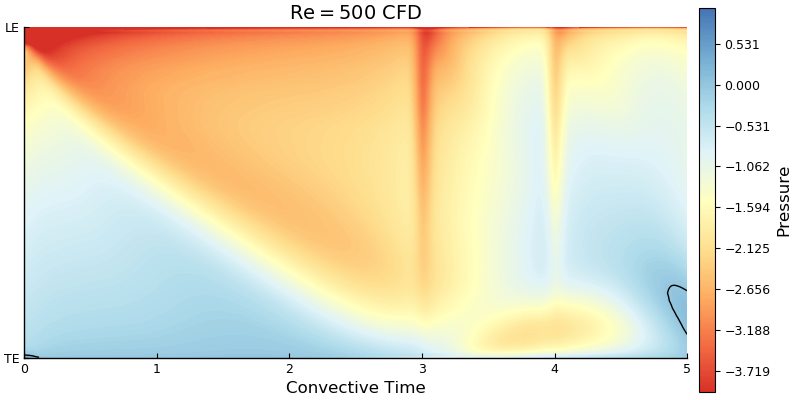

In [93]:
sch = ColorSchemes.RdYlBu_9.colors
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    #model_pressures = hcat((measure_state(mean(states[i+1]), t, config, pressure_taps) for (i,t) in enumerate(T))...),
    cfd_pressures = 2hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
        
    plt = plot(size = (800, 400))
    contourf!(T, s, cfd_pressures, title = ["\$\\mathrm{Re} = 500\$ CFD" "EnKF Mean"],
        levels = range(-4.0, stop = 1, length = 161), clims = (-4, 1), color = cgrad(sch), xlabel = "Convective Time",
        #levels = linspace(-2, 2, 151), clims = (-2, 0.5), color = cgrad(reverse(colormap(:rainbow))), xlabel = ["Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = sch[1],colorbar_title="Pressure")
        #yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap(:rainbow)[end], colorbar_title="Pressure")
    contour!(T, s, cfd_pressures,levels=0:0,seriescolor=:black)
end
# savefig("test1.pdf")
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/pressure_comparison.pdf")

## Model Formulation

We have a flat plate that is translating at a fixed angle of attack and velocity.
We also use a constant blob radius on all of our vortex elements

In [94]:
struct Config
    N::Int
    L::Float64
    ċ::ComplexF64
    α::Float64
    δ::Float64
    Δt::Float64
    transfer::Bool
end

In [95]:
include("/media/mat/HDD/VortexModels/SparseVortex/Jupyter notebooks/merging_model.jl")

regen_forces (generic function with 1 method)

#### Define propagation function f with merging

In [96]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}

    empty_inds = Vector{Int}[]
    len = Int[]
    ensnew = []
    # predicted_states (with merging)
    states = deepcopy(ENS.S)
    for (i, state) in enumerate(states)
        new_state = state_equation(state, t, config)
        new_blobs, lesp, tesp = state_to_blobs(new_state, config.δ)
        push!(empty_inds, findall(b -> circulation(b) == 0, new_blobs))
        push!(len, length(new_blobs))
        push!(ensnew, new_state)
    end
  
    # trim zeros
    @assert all(len .== len[1])
    toremove = intersect(empty_inds...)
    tokeep = filter(i -> i ∉ toremove, 1:len[1])
    for (i, state) in enumerate(ensnew)
        new_blobs, lesp, tesp = state_to_blobs(state, config.δ)
        ensnew[i] = blobs_to_state(new_blobs[tokeep], lesp, tesp)
    end

    # Wrap into an EnsembleState variable
    ENS.S .= deepcopy(ensnew)
 
    return ENS
    #################### OLD VERSION #####################################
#         # predicted_states (with merging)
#     for (i, state) in enumerate(states[end-1])
#         new_state = state_equation(state, t, config)
#         new_blobs, lesp, tesp = state_to_blobs(new_state, config.δ)
#         push!(empty_inds, findall(b -> circulation(b) == 0, new_blobs))
#         push!(len, length(new_blobs))
#         push!(states[end], new_state)
#     end
    
#     # trim zeros
#     @assert all(len .== len[1])
#     toremove = intersect(empty_inds...)
#     tokeep = filter(i -> i ∉ toremove, 1:len[1])
#     for (i, state) in enumerate(states[end])
#         new_blobs, lesp, tesp = state_to_blobs(state, config.δ)
#         states[end][i] = blobs_to_state(new_blobs[tokeep], lesp, tesp)
#     end
# end
    
end

In [97]:
fprop = PropagationFunction()

PropagationFunction()

In [98]:
# @time f(0.0, ens)

In [99]:
# @time size(ens)

#### Define measurement function m 

In [100]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    return measure_state(s, t, config, pressure_taps)
end

In [101]:
m = MeasurementFunction()

MeasurementFunction()

#### Define real measurement function z

In [102]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    
    real_meas = cfd_pressure(t, pressure_taps, config, pressure_data)
    
    fill!(ENS, real_meas)
    
    return ENS
end

In [103]:
z = RealMeasurementFunction()

RealMeasurementFunction()

In [104]:
config

Config(512, 1.0, 1.0 + 0.0im, 0.3490658503988659, 0.005, 0.01, true)

#### Covariance inflation

In [105]:
β = 1.01

1.01

In [106]:
function additive(NS, αp, αΓ, αlesp, αtesp)
    V = zeros(NS)
    
     if NS > 5
        for i in 1:3:NS-3
            V[i:i+1] = [αp, αp]
            V[i+2]   = αΓ
        end

        # Covariance for LESP
        V[end-1] = αlesp

        # Covariance for TESP
         V[end] = αtesp
    end
    
    return V
end

additive (generic function with 1 method)

In [107]:
# function (RI::RecipeInflation)(ENS::EnsembleState{N, TS}) where {N, TS}
#     # unwrap parameters
#     αp, αΓ, αlesp, αtesp, β = RI.p
    
#     # get size of a member
#     NS = size(ENS.S[1])[1]
    
#     # construct inflation distribution
#     A  = MultiAdditiveInflation(NS, β, MvNormal(zeros(NS),
#         additive(NS, αp, αΓ, αlesp, αtesp)))
    
#     return A(ENS)
# end

In [108]:
function (RI::RecipeInflation)(ENS::EnsembleState{N, TS}) where {N, TS}
    # unwrap parameters
    αp, αΓ, αlesp, αtesp, β, n = RI.p
    
    n = ceil(Int, n)
    
    # get size of a member
    NS = size(ENS.S[1])[1]
    
    Ŝ = mean(deepcopy(ENS))
     
    # Covariance inflation
    for (_,s) in enumerate(ENS.S)
        s .= Ŝ .+ β*(s .- Ŝ)
        # don't perturb the state at the 4 first time steps
        if n > 5
        for i in 1:3:size(Ŝ, 1)-3
            s[i:i+1] += αp*randn(2)
            s[i+2]   += αΓ*randn()
        end
            s[end-1] = s[end-1] + αlesp*randn()
            s[end] = s[end] + αtesp*randn()
        end
    end
    
    return ENS
end

In [109]:
ri = RecipeInflation([1e-5,1e-5, 5e-5,0.0, β, 0])

RecipeInflation(Real[1.0e-5, 1.0e-5, 5.0e-5, 0.0, 1.01, 0.0])

In [110]:
function (::FilteringFunction)(ENS::EnsembleState{N, TS}) where {N, TS}
    
    for s in ENS.S
        clamp(s[end-1],0.0,3.0)
    end
    return ENS
end

In [111]:
g = FilteringFunction()

FilteringFunction()

#### Initialize config

In [112]:
config = let N = 512, L = 1.0, ċ = 1.0,
             α = π/9, δ = 5e-3, Δt = 1e-2

    Config(N, L, ċ, α, δ, Δt, true)
end

Config(512, 1.0, 1.0 + 0.0im, 0.3490658503988659, 0.005, 0.01, true)

In [131]:
N = 50 #50
NZ = 50
isinflated = true
isfiltered = true
isaugmented = true

tf = 5.0
pressure_taps = 10:10:config.N-10
T = 0:config.Δt:tf

0.0:0.01:5.0

In [132]:
ϵ = AdditiveInflation(MvNormal(zeros(NZ), 1.0*10^-4*I))

AdditiveInflation{50}(IsoNormal(
dim: 50
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0e-8 0.0 … 0.0 0.0; 0.0 1.0e-8 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-8 0.0; 0.0 0.0 … 0.0 1.0e-8]
)
)

#### Distribution perturbation initial state

In [133]:
lesp₀ = 0.5 #0.5
tesp₀ = 0.0
lesprand = 0.1 #0.1
Distx₀ = TupleProduct((TruncatedNormal(lesp₀, lesprand, 0.0, 3.0),
            Normal(tesp₀, 0.0)))
ens = initialize(N, Distx₀)

states = [deepcopy(ens.S)]#[map((a,b) -> [a, b], lesps, tesps)];

covs = [];

η = 1e-4

0.0001

In [134]:
enkf = ENKF(N, NZ, fprop, ri, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{50,50}(PropagationFunction(), RecipeInflation(Real[1.0e-5, 1.0e-5, 5.0e-5, 0.0, 1.01, 501]), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{50}(IsoNormal(
dim: 50
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0e-8 0.0 … 0.0 0.0; 0.0 1.0e-8 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-8 0.0; 0.0 0.0 … 0.0 1.0e-8]
)
), true, true, true)

In [56]:
tf = 5.0
pressure_taps = 10:10:config.N-10
T = 0:config.Δt:tf
η = 1e-4
α = 1.01
isenkf = true

@showprogress for (n,t) in enumerate(T)
    
    push!(states, [])
    global ens
#     global states
##########################################################################
    "Propagate each ensemble member"
#     ens = EnsembleState(deepcopy(states[end]))
    enkf.f(t, ens)

    
    
    
#     push!(states, [])
#     empty_inds = Vector{Int}[]
#     len = Int[]
    
#     # predicted_states (with merging)
#     for (i, state) in enumerate(states[end-1])
#         new_state = state_equation(state, t, config)
#         new_blobs, lesp, tesp = state_to_blobs(new_state, config.δ)
#         push!(empty_inds, findall(b -> circulation(b) == 0, new_blobs))
#         push!(len, length(new_blobs))
#         push!(states[end], new_state)
#     end
    
#     # trim zeros
#     @assert all(len .== len[1])
#     toremove = intersect(empty_inds...)
#     tokeep = filter(i -> i ∉ toremove, 1:len[1])
#     for (i, state) in enumerate(states[end])
#         new_blobs, lesp, tesp = state_to_blobs(state, config.δ)
#         states[end][i] = blobs_to_state(new_blobs[tokeep], lesp, tesp)
#     end
    


##########################################################################
    "Covariance inflation if 'isinflated==true' "
    
#     ens = EnsembleState(deepcopy(states[end]))
    
    ri.p[6] = deepcopy(n)
    
    if enkf.isinflated ==true
        enkf.A(ens)
    end
    
    "State filtering if 'isfiltered==true' "
    if enkf.isfiltered ==true
        enkf.G(ens)
    end
    
#     states[end] = deepcopy(ens.S)
    
    
#     mean_state = mean(states[end])
    
#     # Covariance inflation
#     for (j,x) in enumerate(states[end])
#         x .= mean_state .+ 1.01*(x .- mean_state)
#         if n > 5
#         for i in 1:3:size(mean_state, 1)-3
#             x[i:i+1] += 1e-5*randn(2)
#             x[i+2]   += 1e-5*randn()
#         end
#                 x[end-1] = clamp(x[end-1] + 5e-5*randn(), 0.0, 3.0)
#         end
#     end
    
###########################################################################
    "Compute mean and deviation"
#     ens = EnsembleState(deepcopy(states[end]))
#     ensbis = deepcopy(ens)

    ensfluc = EnsembleState(N, ens.S[1])

    deviation(ensfluc, ens)
    
#     println(norm(ens.S - ensbis.S))

    A′ = hcat(ensfluc)
    
    # Compute deviation from mean state

    
#     mean_state .= mean(ens)
    
#     mean_state .= mean(states[end])
#     A′ = hcat(states[end]...)
#     A′ .-= mean_state
    
#     println(norm(A′ - A′temp))


##########################################################################    
    "Compute measurement"
    
    mens = EnsembleState(N, zeros(NZ))
    
#     ens = EnsembleState(deepcopy(states[end]))
    
    for (i, s) in enumerate(ens.S)
        mens.S[i] .= enkf.m(t, deepcopy(s))
    end
    
    
    # compute measurements
#     P = [measure_state(s, t, config, pressure_taps) for s in states[end]]
    
#     println(norm(hcat(deepcopy(mens)) - hcat(P...)))
    
###########################################################################    
    Â = hcat(deepcopy(mens))
#     # println("good measurement")

    "Compute deviation from measurement of the mean"
    
    Ŝ = mean(deepcopy(ens))
    Â′  = Â .- enkf.m(t, Ŝ)
    
    # compute deviation from measurement of the mean
#     Â = hcat(P...)
#     Â′= Â .- measure_state(mean_state, t, config, pressure_taps)

#     println(norm(Â′ - Âtemp′))
##########################################################################    
    "Get actual measurement"
    zens = EnsembleState(N, zeros(NZ))
    enkf.z(t+config.Δt, zens)
# Dtemp = hcat(zens)    
    
#     # get actual measurements
# D = repeat(cfd_pressure(t+config.Δt, pressure_taps, config, pressure_data), 1, ensemble_size)

# print(norm(D-Dtemp))
    
##########################################################################    
    "Perturb actual measurement"
    enkf.ϵ(zens)

    D = hcat(zens)
    
    
#     # perturbe actual measurements
#     E = η*randn(size(Â′))
#     D .+= E
    
    

##########################################################################
    "Analysis step with representers, Evensen, Leeuwen et al. 1998"

#     if enkf.isaugmented ==true
#     "Construct representers"

    b = ((Â′*Â′') + (N-1)*(cov(enkf.ϵ))*I) \ (D - Â)
#     println(norm())

    Bᵀb = (A′*Â′')*b
    
#     b = ((Â′*Â′') + (ensemble_size-1)*(η^2)*I) \ (D - Â)
#     Bᵀb = (A′*Â′')*b
    
#     println(norm(Bᵀbtemp-Bᵀb))
    
    
    # print(size(Bᵀb))
    # print(size(ens))
    
    
###########################################################################
    "Analysis step"
    
#     ens = EnsembleState(deepcopy(states[end]))
    ens += cut(Bᵀb)


    "State filtering if 'isfiltered==true' "
    if enkf.isfiltered ==true
        enkf.G(ens)
    end
    
    
    states[end] = deepcopy(ens.S)
    
#     for i in 1:ensemble_size
#         states[end][i] .+= Bᵀb[:,i]
#         states[end][i][end-1] = clamp(states[end][i][end-1], 0, 3)
#     end
    
#     mean_state .= mean(states[end])
    
#     println(norm(mean_state - mean(deepcopy(ens))))

#     end

#     return t+Δt, ens
#     push!(ttab, t + config.Δt)
#     push!(enstab, deepcopy(states))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


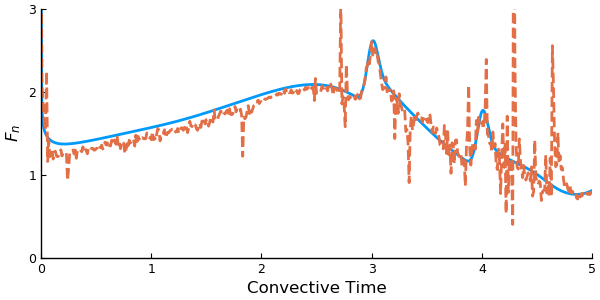

In [57]:
f = regen_forces(T, mean.(states), config);
plot(re500_data["force"]["t"], abs.(re500_data["force"]["F"]), label = "\$\\mathrm{Re} = 500\$ CFD", xlim = (0,5),
legend = false, linewidth = 2)
plot!(T, 2abs.(f)[1:end-1], ylim = (0, 3), label = "EnKF Mean", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
linewidth = 2, linestyle = :dash)
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/force.pdf")

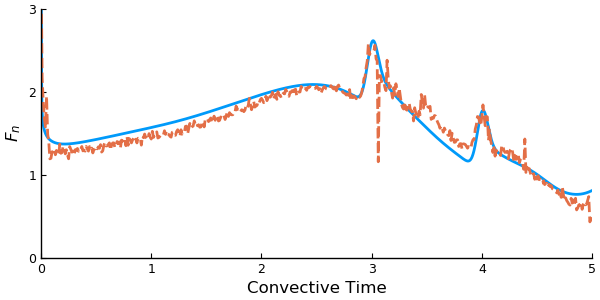

In [215]:
f = regen_forces(T, mean.(states), config);
plot(re500_data["force"]["t"], abs.(re500_data["force"]["F"]), label = "\$\\mathrm{Re} = 500\$ CFD", xlim = (0,5),
legend = false, linewidth = 2)
plot!(T, 2abs.(f)[1:end-1], ylim = (0, 3), label = "EnKF Mean", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
linewidth = 2, linestyle = :dash)
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/force.pdf")

In [135]:
@showprogress for (n,t) in enumerate(T)
    ri.p[6] = deepcopy(n)
    global ens
    t, ens = enkf(t, config.Δt, ens)
    
    push!(states, deepcopy(ens.S))
    # push!(enstab, ens.S)
    # push!(ttab, deepcopy(t))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


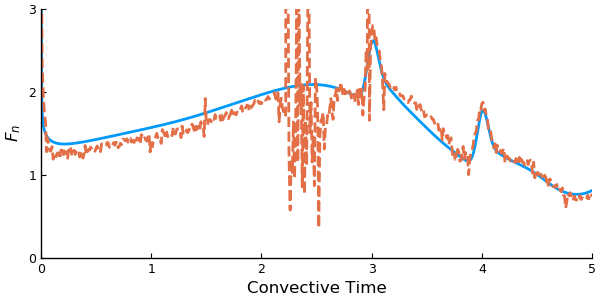

UndefVarError: HAVE_CHOLMOD not defined
Stacktrace:
 [1] step_expr!(::Any, ::JuliaInterpreter.Frame, ::Any, ::Bool) at /home/mat/.julia/packages/JuliaInterpreter/VHjfX/src/interpret.jl:64
 [2] #methods_by_execution!#14(::Bool, ::Bool, ::Function, ::Any, ::Revise.CodeTrackingMethodInfo, ::Dict{Module,Array{Expr,1}}, ::JuliaInterpreter.Frame) at /home/mat/.julia/packages/Revise/agmgx/src/lowered.jl:195
 [3] #methods_by_execution! at ./none:0 [inlined]
 [4] #methods_by_execution!#9(::Base.Iterators.Pairs{Symbol,Bool,Tuple{Symbol},NamedTuple{(:define,),Tuple{Bool}}}, ::Function, ::Any, ::Revise.CodeTrackingMethodInfo, ::Dict{Module,Array{Expr,1}}, ::Module, ::Expr) at /home/mat/.julia/packages/Revise/agmgx/src/lowered.jl:49
 [5] #methods_by_execution! at ./none:0 [inlined]
 [6] #eval_with_signatures#59(::Bool, ::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::Module, ::Expr) at /home/mat/.julia/packages/Revise/agmgx/src/Revise.jl:344
 [7] #eval_with_sign


Stacktrace:
 [1] require(::Module, ::Symbol) at ./loading.jl:823
 [2] eval at ./boot.jl:328 [inlined]
 [3] prepare_thunk(::Module, ::Expr, ::Bool) at /home/mat/.julia/packages/JuliaInterpreter/VHjfX/src/construct.jl:355
 [4] prepare_thunk(::Module, ::Expr, ::Bool) at /home/mat/.julia/packages/JuliaInterpreter/VHjfX/src/construct.jl:361
 [5] prepare_thunk at /home/mat/.julia/packages/JuliaInterpreter/VHjfX/src/construct.jl:347 [inlined]
 [6] #methods_by_execution!#9(::Base.Iterators.Pairs{Symbol,Bool,Tuple{Symbol},NamedTuple{(:define,),Tuple{Bool}}}, ::Function, ::Any, ::Revise.CodeTrackingMethodInfo, ::Dict{Module,Array{Expr,1}}, ::Module, ::Expr) at /home/mat/.julia/packages/Revise/agmgx/src/lowered.jl:47
 [7] #methods_by_execution! at ./none:0 [inlined]
 [8] #eval_with_signatures#59(::Bool, ::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::Module, ::Expr) at /home/mat/.julia/packages/Revise/agmgx/src/Revise.jl:344
 [9] #eval_with_signatures at /ho

 [11] instantiate_sigs! at /home/mat/.julia/packages/Revise/agmgx/src/Revise.jl:349 [inlined]
 [12] maybe_parse_from_cache!(::Revise.PkgData, ::String) at /home/mat/.julia/packages/Revise/agmgx/src/pkgs.jl:224
 [13] (::getfield(Revise, Symbol("##26#27")){String})() at /home/mat/.julia/packages/Revise/agmgx/src/pkgs.jl:370
 [14] with_logstate(::getfield(Revise, Symbol("##26#27")){String}, ::Base.CoreLogging.LogState) at ./logging.jl:395
 [15] with_logger at ./logging.jl:491 [inlined]
 [16] watch_manifest(::String) at /home/mat/.julia/packages/Revise/agmgx/src/pkgs.jl:349
 [17] (::Revise.Rescheduler{typeof(Revise.watch_manifest),Tuple{String}})() at /home/mat/.julia/packages/Revise/agmgx/src/types.jl:235
while evaluating
using ForwardDiff
in module Main.SparseDiffTools
ArgumentError: Package LightGraphs not found in current path:
- Run `import Pkg; Pkg.add("LightGraphs")` to install the LightGraphs package.

Stacktrace:
 [1] require(::Module, ::Symbol) at ./loading.jl:823
 [2] eval at ./

 [6] #methods_by_execution!#9(::Base.Iterators.Pairs{Symbol,Bool,Tuple{Symbol},NamedTuple{(:define,),Tuple{Bool}}}, ::Function, ::Any, ::Revise.CodeTrackingMethodInfo, ::Dict{Module,Array{Expr,1}}, ::Module, ::Expr) at /home/mat/.julia/packages/Revise/agmgx/src/lowered.jl:47
 [7] #methods_by_execution! at ./none:0 [inlined]
 [8] #eval_with_signatures#59(::Bool, ::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::Module, ::Expr) at /home/mat/.julia/packages/Revise/agmgx/src/Revise.jl:344
 [9] #eval_with_signatures at /home/mat/.julia/packages/Revise/agmgx/src/Revise.jl:0 [inlined]
 [10] #instantiate_sigs!#60(::Bool, ::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::OrderedCollections.OrderedDict{Module,OrderedCollections.OrderedDict{Revise.RelocatableExpr,Union{Nothing, Array{Any,1}}}}) at /home/mat/.julia/packages/Revise/agmgx/src/Revise.jl:352
 [11] instantiate_sigs! at /home/mat/.julia/packages/Revise/agmgx/src/Rev

 [17] (::Revise.Rescheduler{typeof(Revise.watch_manifest),Tuple{String}})() at /home/mat/.julia/packages/Revise/agmgx/src/types.jl:235
while evaluating
using ForwardDiff: Dual, jacobian, partials, DEFAULT_CHUNK_THRESHOLD
in module Main.SparseDiffTools
ArgumentError: Package ArrayInterface not found in current path:
- Run `import Pkg; Pkg.add("ArrayInterface")` to install the ArrayInterface package.

Stacktrace:
 [1] require(::Module, ::Symbol) at ./loading.jl:823
 [2] eval at ./boot.jl:328 [inlined]
 [3] prepare_thunk(::Module, ::Expr, ::Bool) at /home/mat/.julia/packages/JuliaInterpreter/VHjfX/src/construct.jl:355
 [4] prepare_thunk(::Module, ::Expr, ::Bool) at /home/mat/.julia/packages/JuliaInterpreter/VHjfX/src/construct.jl:361
 [5] prepare_thunk at /home/mat/.julia/packages/JuliaInterpreter/VHjfX/src/construct.jl:347 [inlined]
 [6] #methods_by_execution!#9(::Base.Iterators.Pairs{Symbol,Bool,Tuple{Symbol},NamedTuple{(:define,),Tuple{Bool}}}, ::Function, ::Any, ::Revise.CodeTrackingM

In [137]:
f = regen_forces(T, mean.(states), config);
plot(re500_data["force"]["t"], abs.(re500_data["force"]["F"]), label = "\$\\mathrm{Re} = 500\$ CFD", xlim = (0,5),
legend = false, linewidth = 2)
plot!(T, 2abs.(f)[1:end-1], ylim = (0, 3), label = "EnKF Mean", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
linewidth = 2, linestyle = :dash)
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/force.pdf")

In [574]:
abs.(f)

0-element Array{Float64,1}

In [575]:
tf = 5.0
pressure_taps = 10:10:config.N-10
T = 0:config.Δt:tf
ϵ = 1e-4
α = 1.01
isenkf = true

@showprogress for (n,t) in enumerate(T)
    N = length(ens)
    NZ = meas_size
#     global ens
#     global states
##########################################################################
    "Propagate each ensemble member"
#     enkf.f(t, ens)
    
    push!(states, [])
    empty_inds = Vector{Int}[]
    len = Int[]
    
    # predicted_states (with merging)
    for (i, state) in enumerate(states[end-1])
        new_state = state_equation(state, t, config)
        new_blobs, lesp, tesp = state_to_blobs(new_state, config.δ)
        push!(empty_inds, findall(b -> circulation(b) == 0, new_blobs))
        push!(len, length(new_blobs))
        push!(states[end], new_state)
    end
    
    # trim zeros
    @assert all(len .== len[1])
    toremove = intersect(empty_inds...)
    tokeep = filter(i -> i ∉ toremove, 1:len[1])
    for (i, state) in enumerate(states[end])
        new_blobs, lesp, tesp = state_to_blobs(state, config.δ)
        states[end][i] = blobs_to_state(new_blobs[tokeep], lesp, tesp)
    end
    


##########################################################################
    "Covariance inflation if 'isinflated==true' "
#     if enkf.isinflated ==true
#         enkf.A(ens)
#     end
    
    "State filtering if 'isfiltered==true' "
#     if enkf.isfiltered ==true
#         enkf.G(ens)
#     end

#     states = deepcopy(ens.S)
    
    mean_state = mean(states[end])
    
    # Covariance inflation
    for (j,x) in enumerate(states[end])
        x .= mean_state .+ 1.01*(x .- mean_state)
        if n > 5
        for i in 1:3:size(mean_state, 1)-3
            x[i:i+1] += 1e-5*randn(2)
            x[i+2]   += 1e-5*randn()
        end
                x[end-1] = clamp(x[end-1] + 5e-5*randn(), 0.0, 3.0)
        end
    end
    
###########################################################################
    "Compute mean and deviation"
    
#     Ŝ = deepcopy(mean(ens))

#     ensfluc = EnsembleState(N, ens.S[1])

#     deviation(ensfluc, ens)

#     A′ = hcat(ensfluc)
    
    # Compute deviation from mean state

    
#     mean_state .= mean(ens)
    
    mean_state .= mean(states[end])
    A′ = hcat(states[end]...)
    A′ .-= mean_state


##########################################################################    
    "Compute measurement"
    
#     mens = EnsembleState(N, zeros(NZ))

#     for (i, s) in enumerate(ens.S)
#         mens.S[i] = enkf.m(t, deepcopy(s))
#     end
    
    # compute measurements
    P = [measure_state(s, t, config, pressure_taps) for s in states[end]]
    
    
###########################################################################    
#     Â = hcat(deepcopy(mens))
#     # println("good measurement")

    "Compute deviation from measurement of the mean"
#     Â′  = Â .- enkf.m(t, Ŝ)
    
    # compute deviation from measurement of the mean
    Â = hcat(P...)
    Â′= Â .- measure_state(mean_state, t, config, pressure_taps)


##########################################################################    
    "Get actual measurement"
#     zens = EnsembleState(N, zeros(NZ))
#     enkf.z(t+config.Δt, zens)
    
    
    # get actual measurements
D = repeat(cfd_pressure(t+config.Δt, pressure_taps, config, pressure_data), 1, ensemble_size)

    
##########################################################################    
    "Perturb actual measurement"
#     enkf.ϵ(zens)

#     D = hcat(zens)
    
    # perturbe actual measurements
    E = η*randn(size(Â′))
    D .+= E
    
    

##########################################################################
    "Analysis step with representers, Evensen, Leeuwen et al. 1998"

#     if enkf.isaugmented ==true
#     "Construct representers"

#     b = ((Â′*Â′') + (N-1)*cov(enkf.ϵ)*I) \ (D - Â)

#     Bᵀb = (A′*Â′')*b
    
    b = ((Â′*Â′') + (ensemble_size-1)*(η^2)*I) \ (D - Â)
    Bᵀb = (A′*Â′')*b
    
    
    # print(size(Bᵀb))
    # print(size(ens))
    
    
###########################################################################
#     "Analysis step"
#     ens += cut(Bᵀb)


#     "State filtering if 'isfiltered==true' "
#     if enkf.isfiltered ==true
#         enkf.G(ens)
#     end
    
    for i in 1:ensemble_size
        states[end][i] .+= Bᵀb[:,i]
        states[end][i][end-1] = clamp(states[end][i][end-1], 0, 3)
    end
    
    mean_state .= mean(states[end])

#     end

#     return t+Δt, ens
#     push!(ttab, t + config.Δt)
#     push!(enstab, states)
end

Progress:  61%|█████████████████████████▎               |  ETA: 0:00:37

InterruptException: InterruptException:

In [576]:
tf = 5.0
pressure_taps = 10:10:config.N-10
T = 0:config.Δt:tf
ϵ = 1e-4
α = 1.01
isenkf = true
@showprogress for (n,t) in enumerate(T)
    push!(states, [])
    empty_inds = Vector{Int}[]
    len = Int[]
    
    # predicted_states (with merging)
    for (i, state) in enumerate(states[end-1])
        new_state = state_equation(state, t, config)
        new_blobs, lesp, tesp = state_to_blobs(new_state, config.δ)
        push!(empty_inds, findall(b -> circulation(b) == 0, new_blobs))
        push!(len, length(new_blobs))
        push!(states[end], new_state)
    end
    
    # trim zeros
    @assert all(len .== len[1])
    toremove = intersect(empty_inds...)
    tokeep = filter(i -> i ∉ toremove, 1:len[1])
    for (i, state) in enumerate(states[end])
        new_blobs, lesp, tesp = state_to_blobs(state, config.δ)
        states[end][i] = blobs_to_state(new_blobs[tokeep], lesp, tesp)
    end
    
    mean_state = mean(states[end])
    
    # Covariance inflation
    if isenkf
    for (j,x) in enumerate(states[end])
        x .= mean_state .+ α*(x .- mean_state)
        if n > 5
        for i in 1:3:size(mean_state, 1)-3
            x[i:i+1] += 1e-5*randn(2)
            x[i+2]   += 1e-5*randn()
        end
                x[end-1] = clamp(x[end-1] + 5e-5*randn(), 0.0, 3.0)
        end
    end
    mean_state .= mean(states[end])
    
    # Compute deviation from mean state
    A′ = hcat(states[end]...)
    A′ .-= mean_state

    # compute measurements
    P = [measure_state(s, t, config, pressure_taps) for s in states[end]]

    # compute deviation from measurement of the mean
    Â = hcat(P...)
    Â′= Â .- measure_state(mean_state, t, config, pressure_taps)


    # get actual measurements
    D = repeat(cfd_pressure(t+config.Δt, pressure_taps, config, pressure_data), 1, ensemble_size)

    # perturbe actual measurements
    E = ϵ*randn(size(Â′))
    D .+= E

    b = ((Â′*Â′') + (ensemble_size-1)*(ϵ^2)*I) \ (D - Â)
    Bᵀb = (A′*Â′')*b


    for i in 1:ensemble_size
        states[end][i] .+= Bᵀb[:,i]
        states[end][i][end-1] = clamp(states[end][i][end-1], 0, 3)
    end
    
    mean_state .= mean(states[end])
    # Compute deviation from mean state
    A′ = hcat(states[end]...)
    A′ .-= mean_state
    push!(covs, A′*A′')
    end
    
end

DimensionMismatch: DimensionMismatch("array could not be broadcast to match destination")

One of the ensemble member

In [577]:

ϵ = 1e-4
α = 1.01
isenkf = true
@showprogress for (n,t) in enumerate(T)
    push!(states, [])
    empty_inds = Vector{Int}[]
    len = Int[]
    
    # predicted_states (with merging)
    for (i, state) in enumerate(states[end-1])
        new_state = state_equation(state, t, config)
        new_blobs, lesp, tesp = state_to_blobs(new_state, config.δ)
        push!(empty_inds, findall(b -> circulation(b) == 0, new_blobs))
        push!(len, length(new_blobs))
        push!(states[end], new_state)
    end
    
    # trim zeros
    @assert all(len .== len[1])
    toremove = intersect(empty_inds...)
    tokeep = filter(i -> i ∉ toremove, 1:len[1])
    for (i, state) in enumerate(states[end])
        new_blobs, lesp, tesp = state_to_blobs(state, config.δ)
        states[end][i] = blobs_to_state(new_blobs[tokeep], lesp, tesp)
    end
    
    mean_state = mean(states[end])
    
    # Covariance inflation
    if isenkf
    for (j,x) in enumerate(states[end])
        x .= mean_state .+ α*(x .- mean_state)
        if n > 5
        for i in 1:3:size(mean_state, 1)-3
            x[i:i+1] += 1e-5*randn(2)
            x[i+2]   += 1e-5*randn()
        end
                x[end-1] = clamp(x[end-1] + 5e-5*randn(), 0.0, 3.0)
        end
    end
    mean_state .= mean(states[end])
    
    # Compute deviation from mean state
    A′ = hcat(states[end]...)
    A′ .-= mean_state

    # compute measurements
    P = [measure_state(s, t, config, pressure_taps) for s in states[end]]

    # compute deviation from measurement of the mean
    Â = hcat(P...)
    Â′= Â .- measure_state(mean_state, t, config, pressure_taps)


    # get actual measurements
    D = repeat(cfd_pressure(t+config.Δt, pressure_taps, config, pressure_data), 1, ensemble_size)

    # perturbe actual measurements
    E = ϵ*randn(size(Â′))
    D .+= E

    b = ((Â′*Â′') + (ensemble_size-1)*(ϵ^2)*I) \ (D - Â)
    Bᵀb = (A′*Â′')*b


    for i in 1:ensemble_size
        states[end][i] .+= Bᵀb[:,i]
        states[end][i][end-1] = clamp(states[end][i][end-1], 0, 3)
    end
    
    mean_state .= mean(states[end])
    # Compute deviation from mean state
    A′ = hcat(states[end]...)
    A′ .-= mean_state
    push!(covs, A′*A′')
    end
    
end

DimensionMismatch: DimensionMismatch("array could not be broadcast to match destination")

In [578]:
member_state(ensemble_state, i) =  [ensemble_state[t][i] for t = 1:size(ensemble_state,1)]

member_state (generic function with 1 method)

In [579]:
member_state(states,10)[4] - states[4][10]

member_state(states,50)[150] - states[150][50];

BoundsError: BoundsError: attempt to access 2-element Array{Array{Float64,1},1} at index [10]

In [580]:
mean.(states)[4]

20-element Array{Float64,1}:
  0.4997659794938844   
  0.18134935773014457  
 -0.010890823597862857 
 -0.4643504918481886   
 -0.1695835153903572   
 -0.16026700306495217  
  0.4569735045792772   
  0.1674518119307742   
  0.015001972995016842 
 -0.49829991627617914  
 -0.15899666307221186  
 -0.017594881638576226 
  0.4818697713736404   
  0.1649349254260933   
  0.036704981609432905 
 -0.4745649245225691   
 -0.18212170235903538  
 -0.0035193335797679536
  0.5160343878997691   
  0.0                  

In [581]:
member_state(states,25)[150] 

BoundsError: BoundsError: attempt to access 2-element Array{Array{Float64,1},1} at index [25]

In [582]:
f1 = regen_forces(T, member_state(states,1), config);
plot(re500_data["force"]["t"], abs.(re500_data["force"]["F"]), label = "\$\\mathrm{Re} = 500\$ CFD", xlim = (0,5),
legend = false, linewidth = 2)
plot!(T, 2abs.(f1)[1:end-1], ylim = (0, 3), label = "EnKF Mean", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
linewidth = 2, linestyle = :dash)
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/force.pdf")

BoundsError: BoundsError: attempt to access 501-element StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}} at index [502]

In [583]:
# plt = plot(re500_data["force"]["t"], abs.(re500_data["force"]["F"]), label = "\$\\mathrm{Re} = 500\$ CFD", xlim = (0,5),
# legend = false, linewidth = 2)
# for i = 1:10#ensemble_size

f = regen_forces(T, member_state(states,50), config);

plot!(T, 2abs.(f)[1:end-1], ylim = (0, 3), label = "EnKF Mean", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
linewidth = 1, linestyle = :dash)
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/force.pdf")
# end
# plt

BoundsError: BoundsError: attempt to access 2-element Array{Array{Float64,1},1} at index [50]

In [584]:
f1 = regen_forces(T, member_state(states,10), config);
f2 = regen_forces(T, member_state(states,50), config);

BoundsError: BoundsError: attempt to access 2-element Array{Array{Float64,1},1} at index [10]

In [585]:
plot(T, 2abs.(f1)[1:end-1])#, ylim = (0, 3), label = "EnKF Mean", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
# linewidth = 2, linestyle = :dash)
plot!(T, 2abs.(f2)[1:end-1])#, ylim = (0, 3), label = "EnKF Mean", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
# linewidth = 2, linestyle = :dash)

UndefVarError: UndefVarError: f1 not defined

In [586]:
plot(T, 2abs.(f1)[1:end-1])#, ylim = (0, 3), label = "EnKF Mean", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
# linewidth = 2, linestyle = :dash)
plot!(T, 2abs.(f2)[1:end-1])#, ylim = (0, 3), label = "EnKF Mean", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
# linewidth = 2, linestyle = :dash)

UndefVarError: UndefVarError: f1 not defined

In [587]:
# f = regen_forces(T, mean.(states), config);
# plot(re500_data["force"]["t"], abs.(re500_data["force"]["F"]), label = "\$\\mathrm{Re} = 500\$ CFD", xlim = (0,5),
# legend = false, linewidth = 2)
# plot!(T, 2abs.(f)[1:end-1], ylim = (0, 3), label = "EnKF Mean", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
# linewidth = 2, linestyle = :dash)
# # savefig("EnKF\ Results/Re500/2pulse01/no_inflation/force.pdf")

In [588]:
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    model_pressures = hcat((measure_state(mean(states[i+1]), t, config, pressure_taps) for (i,t) in enumerate(T))...),
    cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
    
    plt = plot(layout = (2,1), size = (800, 400))
    contourf!(T, s, [cfd_pressures, model_pressures], title = ["\$\\mathrm{Re} = 500\$ CFD" "EnKF Mean"],
        levels = range(-2.0, stop  = 2.0, length = 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" "Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title="Pressure")
end
# savefig("EnKF\ Results/Re500

Internal error: encountered unexpected error in runtime:
InterruptException()
jl_mutex_unlock at /buildworker/worker/package_linux64/build/src/locks.h:138 [inlined]
jl_typeinf_end at /buildworker/worker/package_linux64/build/src/gf.c:2623
typeinf_ext at ./compiler/typeinfer.jl:577
typeinf_ext at ./compiler/typeinfer.jl:613
jfptr_typeinf_ext_1.clone_1 at /home/mat/julia-1.1.1/lib/julia/sys.so (unknown line)
jl_apply_generic at /buildworker/worker/package_linux64/build/src/gf.c:2197
jl_apply at /buildworker/worker/package_linux64/build/src/julia.h:1571 [inlined]
jl_type_infer at /buildworker/worker/package_linux64/build/src/gf.c:255
jl_compile_method_internal at /buildworker/worker/package_linux64/build/src/gf.c:1797 [inlined]
jl_fptr_trampoline at /buildworker/worker/package_linux64/build/src/gf.c:1841
jl_apply_generic at /buildworker/worker/package_linux64/build/src/gf.c:2197
do_call at /buildworker/worker/package_linux64/build/src/interpreter.c:323
eval_value at /buildworker/worker/pa

ErrorException: type Array has no field surf

In [589]:
# let s = [-0.5config.L*cos(θ) for θ in linspace(0, π, config.N)][pressure_taps],
#     model_pressures = hcat((measure_state(mean(states[i+1]), t, config, pressure_taps) for (i,t) in enumerate(T))...),
#     cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
    
#     plt = plot(layout = (2,1), size = (800, 400))
#     contourf!(T, s, [cfd_pressures, model_pressures], title = ["\$\\mathrm{Re} = 500\$ CFD" "EnKF Mean"],
#         levels = linspace(-2, 2, 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" "Convective Time"],
#         yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title="Pressure")
# end
# # savefig("EnKF\ Results/Re500/2pulse01/no_inflation/pressure_comparison.pdf")

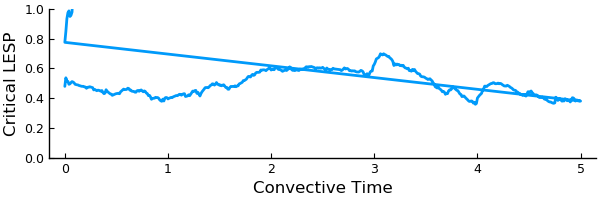

In [590]:
plot(T, [mean((x -> x[end-1]).(s)) for s in states[2:end]], legend = false,
    xlabel = "Convective Time", ylabel = "Critical LESP", linewidth = 2, size = (600, 200),
ylim = (0, 1))
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/lesp.pdf")

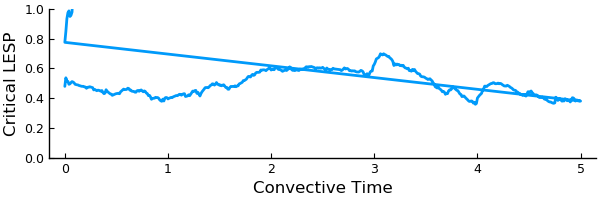

In [591]:
plot(T, [mean((x -> x[end-1]).(s)) for s in states[2:end]], legend = false,
    xlabel = "Convective Time", ylabel = "Critical LESP", linewidth = 2, size = (600, 200),
ylim = (0, 1))
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/lesp.pdf")

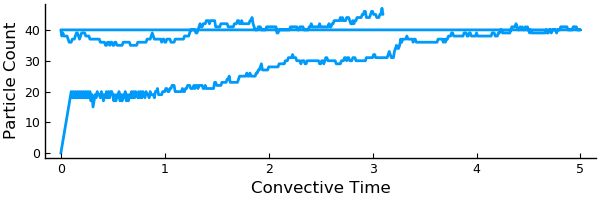

In [592]:
plot(T, [(length(s[1]) - 2) ÷ 3 for s in states[1:end-1]], linewidth = 2, size = (600, 200), legend = false,
xlabel = "Convective Time", ylabel="Particle Count")
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/particle_count.pdf")

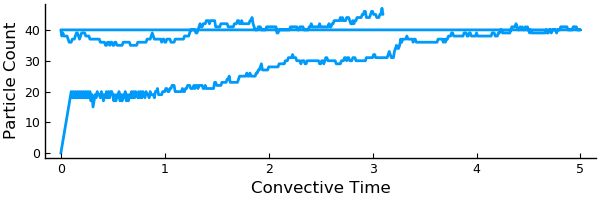

In [593]:
plot(T, [(length(s[1]) - 2) ÷ 3 for s in states[1:end-1]], linewidth = 2, size = (600, 200), legend = false,
xlabel = "Convective Time", ylabel="Particle Count")
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/particle_count.pdf")

In [594]:
plt = plot(layout = (2,2), size = (800, 500), legend = false)
plot!(plt[1], T, map(covs) do P
        mean(diag(P)[1:3:end-3]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_x^2\$")
plot!(plt[2], T, map(covs) do P
        mean(diag(P)[2:3:end-3]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_y^2\$")
plot!(plt[3],T,  map(covs) do P
        mean(diag(P)[3:3:end-3]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_\\Gamma^2\$")
plot!(plt[4], T, map(covs) do P
        mean(diag(P)[end-1]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_\\mathrm{LESP}^2\$")
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/covariance.pdf")

DivideError: DivideError: integer division error

### Snapshot Figures

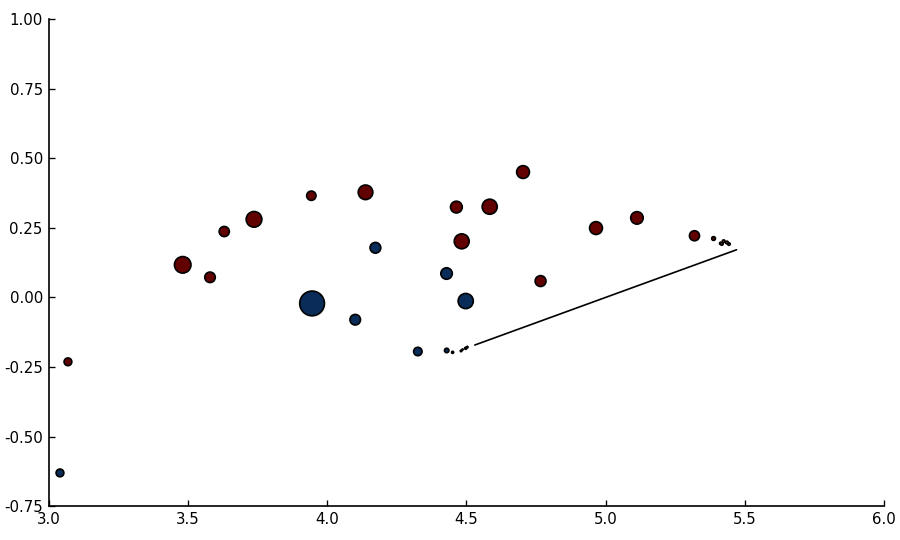

In [595]:
n = 500
# for n in [250, 300, 350, 400, 450, 500]
plt = plot(colorbar = :none, size = (750, 450), dpi = 120)
plot!(plt, Plate(config.N, config.L, config.Δt*n, config.α), ratio = 1, legend = false)
plot!(plt, state_to_blobs(mean(states[n]), config.δ)[1], markersize = 15sqrt.(abs.(mean(states[n])[3:3:end-2])), markerstrokealpha = 0, color = cgrad(reverse(colormap("RdBu"))), clim = (-0.02, 0.02), 
    ratio = 1, xlim = (n/100 - 2, n/100 + 1), ylim = (-0.75,1), xticks = (n/100 - 2):0.5:(n/100 + 1)
)
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/enkf_t$(lpad(n, 3, 0)).pdf")

# plt = plot(colorbar = :none, size = (750, 450), dpi = 120)
# contour!(plt, n/100 - re500_data["vorticity"]["x"], re500_data["vorticity"]["y"],
#     transpose(re500_data["vorticity"]["vorticity"][n÷5]), levels = linspace(-30, 30, 100),
#     color = :RdBu, clim = (-20, 20),
#     xlim = (n/100 - 2, n/100 + 1), ylim = (-0.75, 1), ratio = 1, legend = :none, xticks = (n/100 - 2):0.5:(n/100 + 1))
# savefig("EnKF\ Results/Re500/2pulse01/multiplicative_inflation/cfd_t$(lpad(n, 3, 0)).pdf")
# end

In [596]:
typeof(reverse(colormap("RdBu")))

Array{RGB{Float64},1}

In [597]:
ColorSchemes.RdBu_9)

LoadError: syntax: extra token ")" after end of expression

In [598]:
cgrad(ColorSchemes.RdBu_9)

MethodError: MethodError: no method matching cgrad_colors(::ColorScheme)
Closest candidates are:
  cgrad_colors(!Matched::Array{RGBA{Float64},1}) at /home/mat/.julia/packages/PlotUtils/35TGG/src/color_gradients.jl:173
  cgrad_colors(!Matched::ColorGradient) at /home/mat/.julia/packages/PlotUtils/35TGG/src/color_gradients.jl:172
  cgrad_colors(!Matched::Symbol; color_library) at /home/mat/.julia/packages/PlotUtils/35TGG/src/color_gradients.jl:164
  ...

In [599]:
f = regen_forces(T, mean.(states), config);
n = 350
# @showprogress for (i,n) in enumerate(5:5:500)
l = @layout [  grid(1, 2)
               b{0.5h} ]

plt = plot(layout = l, colorbar = :none, size = (1000, 800), dpi = 120)
plot!(plt[1], Plate(config.N, config.L, config.Δt*n, config.α), ratio = 1, legend = false)
plot!(plt[1], state_to_blobs(mean(states[n]), config.δ)[1], markersize = 15sqrt.(abs.(mean(states[n])[3:3:end-2])), markerstrokealpha = 0, color = cgrad(reverse(colormap("RdBu"))), clim = (-0.02, 0.02), 
    ratio = 1, xlim = (n/100 - 2, n/100 + 1), ylim = (-0.75,1),
    xticks = [], yticks = [])
    contour!(plt[2], re500_data["vorticity"]["x"], re500_data["vorticity"]["y"],
    reverse(transpose(re500_data["vorticity"]["vorticity"][n÷5 + 1]), dims = 2), levels = range(-20.0, stop = 20.0, length = 100),
    color = cgrad((colormap("RdBu"))), clim = (-20, 20),
    xlim = (1.5, 4.5), ylim = (-0.75, 1), ratio = 1, legend = :none, xticks = [], yticks = []
)   
plot!(plt[3], re500_data["force"]["t"][1:10n], abs.(re500_data["force"]["F"][1:10n]), linewidth = 2, label = "\$\\mathrm{Re} = 500\$ CFD")
plot!(plt[3], T[1:n], 2abs.(f)[1:n], label = "EnKF Mean", linewidth = 2, linestyle = :dash, ylabel="\$F_n\$", xlabel = "Convective Time", xlim = (0, 5), ylim = (0, 3))
# plot!(plt[3], T[1:n], abs.(re500_data["force"]["F"])[1:n], label = "EnKF Mean", linewidth = 2, linestyle = :dash, ylabel="\$F_n\$", xlabel = "Convective Time", xlim = (0, 5), ylim = (0, 3))

# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/state_$(lpad(i,3,0)).png")
# end

BoundsError: BoundsError: attempt to access 501-element StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}} at index [502]

In [600]:
# # for n in [3, 4, 6, 8]
# n = 3
# let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
#     model_pressures = hcat((measure_state(states[i+1][n], t, config, pressure_taps) for (i,t) in enumerate(T[1:300]))...),
# #     cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
    
#     plt = plot(size = (800, 200))
#     contourf!(T[1:300], s, model_pressures,
#         levels = range(-2.0, stop = 2.0, length = 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" "Convective Time"],
#         yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title="Pressure")
# end
# savefig("EnKF\ Results/Ensemble/pressure_n$(lpad(n,2,0)).pdf")
# # end

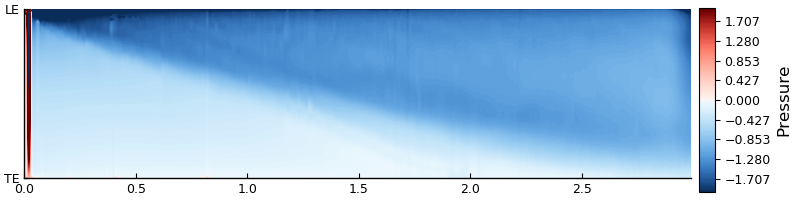

In [601]:
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    model_pressures = hcat((measure_state(states[i+1][1], t, config, pressure_taps) for (i,t) in enumerate(T[1:300]))...),
#     cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
    
    plt = plot(size = (800, 200))
    contourf!(T[1:300], s, model_pressures,
        levels = range(-2.0, stop = 2.0, length = 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" "Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title="Pressure")
end
#savefig("EnKF\ Results/Ensemble/pressure_n$(lpad(n,2,0)).pdf")